In [2]:
import os
import sys
import warnings

ffmpeg_bin_path = r"C:\Users\arezk\AppData\Local\Microsoft\WinGet\Packages\Gyan.FFmpeg_Microsoft.Winget.Source_8wekyb3d8bbwe\ffmpeg-8.0.1-full_build\bin"
os.environ["PATH"] += os.pathsep + ffmpeg_bin_path

warnings.filterwarnings("ignore")
sys.path.append('..')
import musdb

In [3]:
import IPython.display as ipd
import numpy as np
import librosa
import matplotlib.pyplot as plt 
import warnings

In [4]:
# download the dataset if but only thes 7 seconds for each song
mus = musdb.DB(root='../data/musdb7s', download=True)


In [5]:
track = mus[0]  # first track of the dataset

print("Duree:", track.duration)
print("Shape of mix:", track.audio.shape)  #  stéréo
print("Shape vocals:", track.targets['vocals'].audio.shape)
print("Sample rate:", track.rate) 

# 4 stems  are available: :
print(track.targets.keys())

Duree: 6.8
Shape of mix: (300032, 2)
Shape vocals: (300032, 2)
Sample rate: 44100
odict_keys(['vocals', 'drums', 'bass', 'other', 'accompaniment', 'linear_mixture'])


In [6]:
# Mix
print("Mix:")
display(ipd.Audio(track.audio.T, rate=track.rate))

# Vocals
print("Vocals:")
display(ipd.Audio(track.targets['vocals'].audio.T, rate=track.rate))

# instruments without vocals
print("Accompaniment (instruments):")
display(ipd.Audio(track.targets['accompaniment'].audio.T, rate=track.rate))

Mix:


Vocals:


Accompaniment (instruments):


### steps to convert to spectogram


In [7]:
# Load audio
mix_audio = track.audio  
vocal_audio = track.targets['vocals'].audio  
sr_original = track.rate
print("Original sample rate:", sr_original)

Original sample rate: 44100


In [8]:
# Take the mean of 2 channels

mix_mono = np.mean(mix_audio, axis=1)  
vocal_mono = np.mean(vocal_audio, axis=1)  

In [9]:
# Resample

target_sr = 8192


mix_resampled = librosa.resample(mix_mono, orig_sr=sr_original, target_sr=target_sr)
vocal_resampled = librosa.resample(vocal_mono, orig_sr=sr_original, target_sr=target_sr)

print(f"Original length: {len(mix_mono)}")
print(f"Resampled length: {len(mix_resampled)}")

Original length: 300032
Resampled length: 55734


In [10]:
n_fft = 1024
hop_length = 768

# Compute STFT
mix_stft = librosa.stft(mix_resampled, n_fft=n_fft, hop_length=hop_length)
vocal_stft = librosa.stft(vocal_resampled, n_fft=n_fft, hop_length=hop_length)

print(f"STFT shape: {mix_stft.shape}")  # (freq_bins, time_frames

STFT shape: (513, 73)


In [11]:
# Get magnitude
mix_magnitude = np.abs(mix_stft)
vocal_magnitude = np.abs(vocal_stft)

print(f"Magnitude shape: {mix_magnitude.shape}")

Magnitude shape: (513, 73)


In [12]:
# Handle frames for model input

target_frames = 128

def handle_frames(spectrogram, target_frames=128):

    freq_bins, time_frames = spectrogram.shape
    
    if time_frames < target_frames:
        # Padding
        padding = target_frames - time_frames
        spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')
    elif time_frames > target_frames:
        # Extract a random patch of 128 frames
        start_frame = np.random.randint(0, time_frames - target_frames + 1)
        spectrogram = spectrogram[:, start_frame:start_frame + target_frames]
    
    return spectrogram

mix_spec = handle_frames(mix_magnitude, target_frames)
vocal_spec = handle_frames(vocal_magnitude, target_frames)

print(f"Final shape: {mix_spec.shape}")  # Should be (513, 128)

Final shape: (513, 128)


In [13]:
def normalize_spectrogram(spectrogram):
    """
    Normalize spectrogram to [0, 1]
    """
    spec_min = spectrogram.min()
    spec_max = spectrogram.max()
    
    if spec_max - spec_min > 0:
        normalized = (spectrogram - spec_min) / (spec_max - spec_min)
    else:
        normalized = spectrogram
    
    return normalized

mix_normalized = normalize_spectrogram(mix_spec)
vocal_normalized = normalize_spectrogram(vocal_spec)

print(f"Min: {mix_normalized.min()}, Max: {mix_normalized.max()}")

Min: 0.0, Max: 1.0


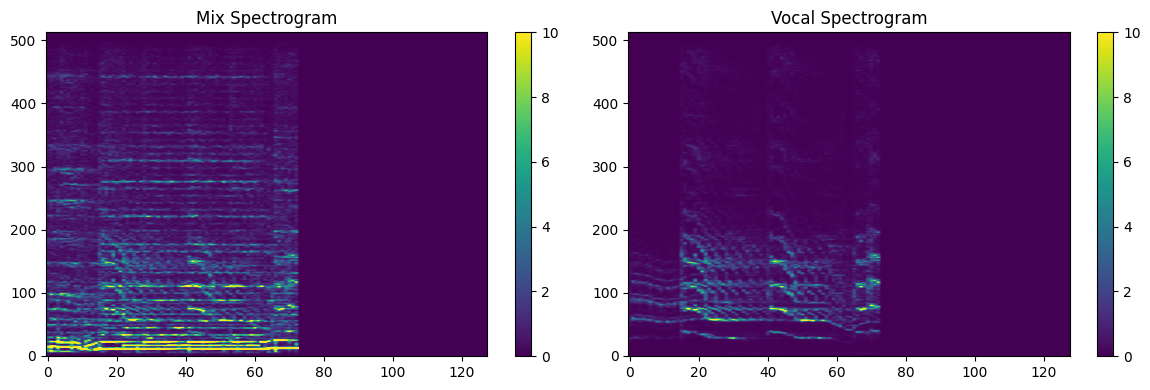

In [18]:
# plot the normalized spectrogram


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mix_spec, aspect='auto', origin='lower', cmap='viridis', vmax=10)
plt.colorbar()
plt.title('Mix Spectrogram')

plt.subplot(1, 2, 2)
plt.imshow(vocal_spec, aspect='auto', origin='lower', cmap='viridis', vmax=10)
plt.colorbar()
plt.title('Vocal Spectrogram')

plt.tight_layout()
plt.show()